In [2]:
# import packages

import numpy as np
from numpy import linspace
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

Before you start designing the detection techniques, make sure you have all needed features (`sentence scores`, `laser scores`, `alti scores`, and the `annotations`)

- Please, refer to this [Readme](https://github.com/andreniyongabo/hallucination_detection_and_mitigation/blob/main/README.md) file to see step by step on how to get these features needed for hallucination detection design and mitigation.

- And refer to [this file](https://docs.google.com/spreadsheets/d/1QGTc-H5-hXnh3W1dbaVQq5xn25jFO9fmypcmE67buho/edit#gid=0) to see the detailed annotations

In [3]:
# paths to data files and directories
src = "eng"
tgt = "kin"
flores_first_100_data_path = f"translations/flores_test/{src}-{tgt}/data_for_eval_100.csv"

# vizualizing the data
df = pd.read_csv(flores_first_100_data_path)
df.head()

,eng,kin,sent_score,laser_score,alti_score,annotation
0,"""We now have 4-month-old mice that are non-dia...","Yongeyeho ati ""ubu dufite impene z'amezi ane z...",-0.844550,0.784786,0.444763,WW
1,"Dr. Ehud Ur, professor of medicine at Dalhousi...","Dr. Ehud Ur, umwarimu wigisha ibijyanye n'ubuv...",-0.688445,0.931296,0.405180,WW
2,"Like some other experts, he is skeptical about...","Kimwe n'abandi bahanga bamwe na bamwe, na we n...",-0.938590,0.856047,0.432933,NT
3,"On Monday, Sara Danius, permanent secretary of...","Ku wa mbere, Sara Danius, umunyamabanga w'igih...",-0.831531,0.932948,0.359460,NT
4,"Danius said, ""Right now we are doing nothing. ...","Danius yagize ati "" Kugeza ubu nta kintu na ki...",-1.160723,0.886903,0.452443,WW


In [4]:
# prepare the data
# we are interested in full sentence hallucinations and natural/correct translations, so we discard the wrong words (WW)
cond = df["annotation"]=="WW"
cond_hl = (df["annotation"]=="DH") | (df["annotation"]=="OH") | (df["annotation"]=="EH") | (df["annotation"]=="SH")
cond_nt = df["annotation"]=="NT"

df.loc[cond,"annotation"]="WW"
df.loc[cond_hl,"annotation"]="hallucination"
df.loc[cond_nt,"annotation"]="natural translation"

df_new = df[df["annotation"]!="WW"]   
    
df_new = df_new.reset_index(drop=True)
df_new.head()

,eng,kin,sent_score,laser_score,alti_score,annotation
0,"Like some other experts, he is skeptical about...","Kimwe n'abandi bahanga bamwe na bamwe, na we n...",-0.938590,0.856047,0.432933,natural translation
1,"On Monday, Sara Danius, permanent secretary of...","Ku wa mbere, Sara Danius, umunyamabanga w'igih...",-0.831531,0.932948,0.359460,natural translation
2,Siminoff said sales boosted after his 2013 app...,Siminoff yavuze ko ibicuruzwa byazamutse nyuma...,-0.724982,0.886111,0.515889,hallucination
3,"In late 2017, Siminoff appeared on shopping te...","Mu mpera z'umwaka wa 2017, Siminoff yagaragaye...",-0.565374,0.890373,0.525525,natural translation
4,Ring also settled a lawsuit with competing sec...,Ring kandi yageze ku masezerano y'urukiko n'ik...,-1.006676,0.835080,0.410035,natural translation


## Halucination detection
### Detection

sent_score_avg: -0.848294845992519

 f1_score: 0.5777777777777777 precision_score: 0.48148148148148145 recall_score: 0.7222222222222222


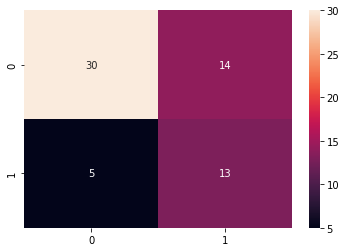

In [5]:
# detection based on sentence scores average

def sent_score_based_detection(df):
    #halluc=1
    #natural_trans=0

    scores_nt = [df.sent_score[i] for i in range(len(df))] 
    avg_score = np.array(scores_nt).sum()/len(scores_nt)
    print("sent_score_avg:", avg_score)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])] # assign 1 to hallucination and 0 to natural translations
    pred_classes = []

    for i,score in enumerate(df["sent_score"]):
        if score <= avg_score:
            pred_classes.append(1)
        else:
            pred_classes.append(0)
    
    
#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

#     print("--"*50)

#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
    
    return f_score, p_score, r_score, conf_matrix, avg_score
    
f_score, p_score, r_score, conf_matrix, _ = sent_score_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/avg_sent_score-based.png",
#                      format='png',dpi=150)
plt.show()


laser_score_avg 0.8663305809677417

 f1_score: 0.5333333333333333 precision_score: 0.4444444444444444 recall_score: 0.6666666666666666


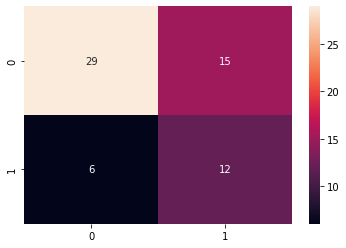

In [6]:
# detection based on laser scores average

def laser_score_based_detection(df):
    #halluc=1
    #natural_trans=0
    
    scores_nt = [df.laser_score[i] for i in range(len(df))] 
    avg_score = np.array(scores_nt).sum()/len(scores_nt)
    print("laser_score_avg", avg_score)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])] # assign 1 to hallucination and 0 to natural translations
    pred_classes = []

    for i, score in enumerate(df["laser_score"]):
        if score <= avg_score:
            pred_classes.append(1)
        else:
            pred_classes.append(0)
    
    
#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

#     print("--"*50)

#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
    
    return f_score, p_score, r_score, conf_matrix, avg_score
    
f_score, p_score, r_score, conf_matrix, _ = laser_score_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/avg_sent_score-based.png",
#                      format='png',dpi=150)
plt.show()


 f1_score: 0.0 precision_score: 0.0 recall_score: 0.0


/public/apps/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


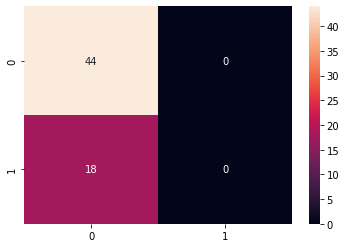

In [7]:
# detection based on alti scores threshold

def alti_score_based_detection(df, alti_threshold=0.3):
    #halluc=1
    #natural_trans=0

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])] # assign 1 to hallucination and 0 to natural translations
    pred_classes = []

    for i, score in enumerate(df["alti_score"]):
        if score <= alti_threshold:
            pred_classes.append(1)
        else:
            pred_classes.append(0)
    
    
#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

#     print("--"*50)

#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j]) 

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
    
    return f_score, p_score, r_score, conf_matrix, alti_threshold
    
f_score, p_score, r_score, conf_matrix, _ = alti_score_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/avg_sent_score-based.png",
#                      format='png',dpi=150)
plt.show()

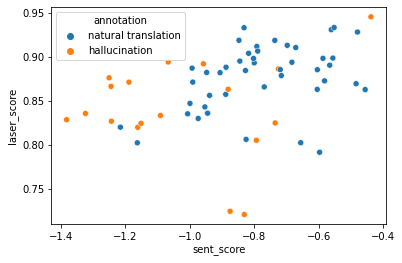

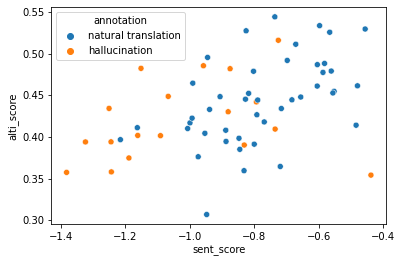

In [8]:
sns.scatterplot(data=df_new, x="sent_score", y="laser_score", hue="annotation")
# plt.savefig("annotation/sent_sim_correlation.png",
#                      format='png',dpi=150)
plt.show()

sns.scatterplot(data=df_new, x="sent_score", y="alti_score", hue="annotation")
# plt.savefig("annotation/sent_sim_correlation.png",
#                      format='png',dpi=150)
plt.show()

sent_avg_score: -0.848294845992519 laser_avg_score: 0.8663305809677417

 f1_score: 0.5 precision_score: 0.5 recall_score: 0.5


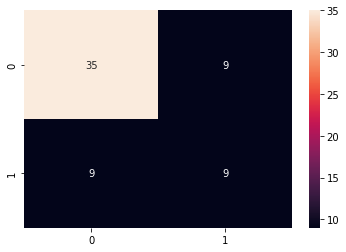

In [12]:
# detection based on both sentence scores average and laser scores average

def sent_laser_AND_based_detection(df):
    #halluc=1
    #natural_trans=0

    sent_scores_nt = [df.sent_score[i] for i in range(len(df))] 
    sent_avg_score = np.array(sent_scores_nt).sum()/len(sent_scores_nt)

    laser_scores_nt = [df.laser_score[i] for i in range(len(df))] # if df.annotation[i]=="natural translation"
    laser_avg_score = np.array(laser_scores_nt).sum()/len(laser_scores_nt)

    print("sent_avg_score:", sent_avg_score, "laser_avg_score:", laser_avg_score)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []

    for i in range(len(df)):
        if df["laser_score"][i] <= laser_avg_score and df["sent_score"][i] <= sent_avg_score:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

# # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

#     print("--"*50)

#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j]) 

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix

f_score, p_score, r_score, conf_matrix = sent_laser_AND_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/sent_sim_correlation-and.png",
#                      format='png',dpi=150)
plt.show()

sent_avg_score: -0.848294845992519 laser_avg_score: 0.8663305809677417

 f1_score: 0.5925925925925926 precision_score: 0.4444444444444444 recall_score: 0.8888888888888888


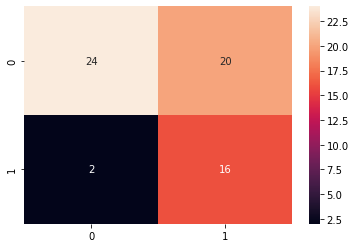

In [18]:
# detection based on both sentence scores average and laser scores average

def sent_laser_OR_based_detection(df):
    #halluc=1
    #natural_trans=0

    sent_scores_nt = [df.sent_score[i] for i in range(len(df))] 
    sent_avg_score = np.array(sent_scores_nt).sum()/len(sent_scores_nt)

    laser_scores_nt = [df.laser_score[i] for i in range(len(df))] # if df.annotation[i]=="natural translation"
    laser_avg_score = np.array(laser_scores_nt).sum()/len(laser_scores_nt)

    print("sent_avg_score:", sent_avg_score, "laser_avg_score:", laser_avg_score)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []

    for i in range(len(df)):
        if df["laser_score"][i] <= laser_avg_score or df["sent_score"][i] <= sent_avg_score:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

#     print("--"*50)

#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j]) 

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix

f_score, p_score, r_score, conf_matrix = sent_laser_OR_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/sent_sim_correlation-and.png",
#                      format='png',dpi=150)
plt.show()

sent_laser_avg: 0.01803573497522292

 f1_score: 0.625 precision_score: 0.5 recall_score: 0.8333333333333334


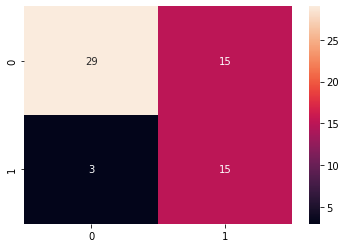

In [19]:
# detection based on both sentence scores average and laser scores average

def sent_laser_AVG_based_detection(df):
    #halluc=1
    #natural_trans=0

    sent_laser_scores = [df.sent_score[i]+df.laser_score[i] for i in range(len(df))] # if df.annotation[i]=="natural translation"
    sent_laser_avg = np.array(sent_laser_scores).sum()/len(sent_laser_scores)
    print("sent_laser_avg:", sent_laser_avg)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []

    for i in range(len(df)):
        if df["laser_score"][i]+df["sent_score"][i] <= sent_laser_avg:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

#     print("--"*50)

#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix

f_score, p_score, r_score, conf_matrix = sent_laser_AVG_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)
 
sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/sent_sim_correlation-and.png",
#                      format='png',dpi=150)
plt.show()

sent_laser_avg: 0.01803573497522292

 f1_score: 0.625 precision_score: 0.5 recall_score: 0.8333333333333334


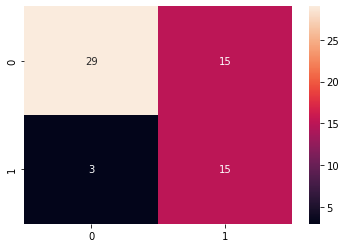

In [20]:
# detection based on both sentence scores average, laser scores average, and alti scores average

def sent_laser_alti_based_detection(df, alti_threshold):
    #halluc=1
    #natural_trans=0

    sent_laser_scores = [df.sent_score[i]+df.laser_score[i] for i in range(len(df))] # if df.annotation[i]=="natural translation"
    sent_laser_avg = np.array(sent_laser_scores).sum()/len(sent_laser_scores)
    print("sent_laser_avg:", sent_laser_avg)

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []

    for i in range(len(df)):
        if (df["laser_score"][i]+df["sent_score"][i]) <= sent_laser_avg or df["alti_score"][i] <= alti_threshold:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

#     print("--"*50)

#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix

alti_threshold = 0.3
f_score, p_score, r_score, conf_matrix = sent_laser_alti_based_detection(df_new, alti_threshold)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)
 
sns.heatmap(conf_matrix, annot=True)
# plt.savefig("annotation/sent_sim_correlation-and.png",
#                      format='png',dpi=150)
plt.show()

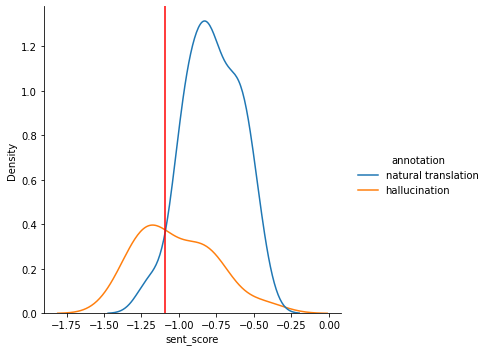

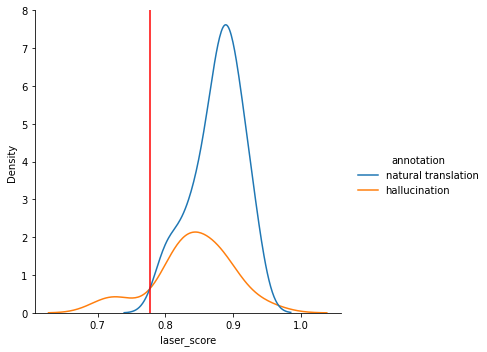

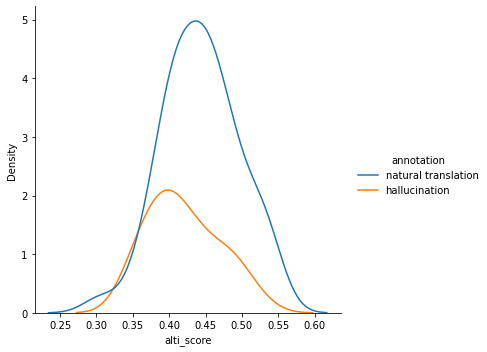

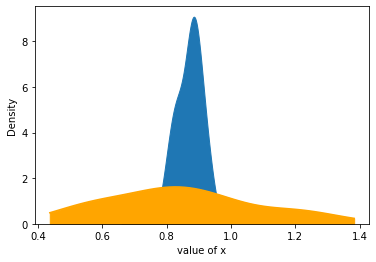

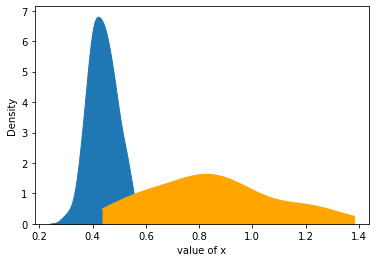

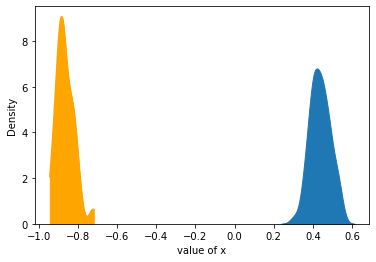

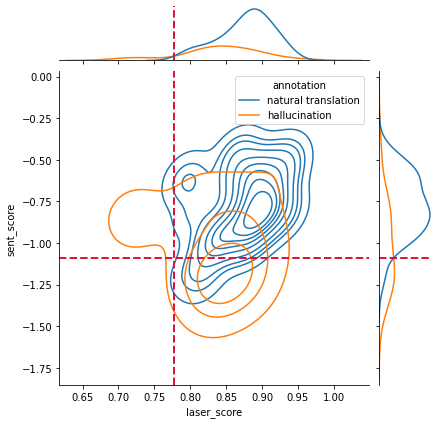

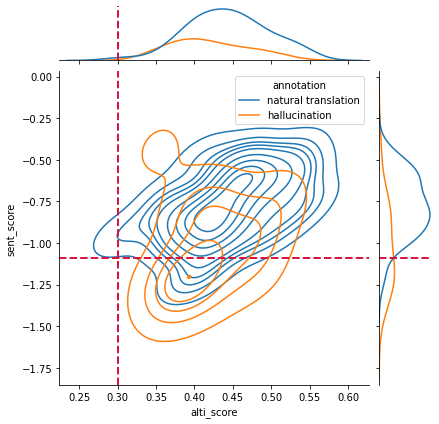

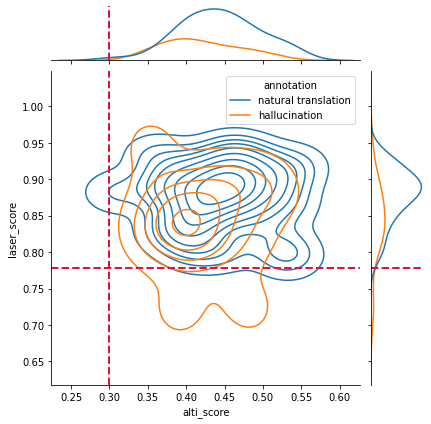

In [73]:
# detection based on the scores distribution

# sentence score distribution
sns.displot(df_new, x="sent_score", kind="kde", hue="annotation")
plt.axvline(-1.09, 0,1.25, color='red')
plt.show()

# similarity score distribution
sns.displot(df_new, x="laser_score", kind="kde", hue="annotation")
plt.axvline(0.778, 0,8, color='red')
plt.show()

# alti score distribution
sns.displot(df_new, x="alti_score", kind="kde", hue="annotation")
plt.show()

# sentence score and similarity score distribution
sns.kdeplot(data=df_new, x="laser_score",  fill=True, alpha=1)
kde = gaussian_kde(df_new.sent_score)
x_range = linspace(min(df_new.sent_score), max(df_new.sent_score), len(df_new.sent_score))
sns.lineplot(x=x_range*-1, y=kde(x_range) * 1, color='orange') # multiply by -1 to reverse axis (mirror plot)
plt.fill_between(x_range*-1, kde(x_range) * 1, color='orange')       
plt.xlabel("value of x")
plt.axhline(y=0, linestyle='-',linewidth=1, color='black')
plt.show()

# sentence score and alti score distribution
sns.kdeplot(data=df_new, x="alti_score",  fill=True, alpha=1)
kde = gaussian_kde(df_new.sent_score)
x_range = linspace(min(df_new.sent_score), max(df_new.sent_score), len(df_new.sent_score))
sns.lineplot(x=x_range*-1, y=kde(x_range) * 1, color='orange') # multiply by -1 to reverse axis (mirror plot)
plt.fill_between(x_range*-1, kde(x_range) * 1, color='orange')       
plt.xlabel("value of x")
plt.axhline(y=0, linestyle='-',linewidth=1, color='black')
plt.show()

# similarity score and alti score distribution
sns.kdeplot(data=df_new, x="alti_score",  fill=True, alpha=1)
kde = gaussian_kde(df_new.laser_score)
x_range = linspace(min(df_new.laser_score), max(df_new.laser_score), len(df_new.laser_score))
sns.lineplot(x=x_range*-1, y=kde(x_range) * 1, color='orange') # multiply by -1 to reverse axis (mirror plot)
plt.fill_between(x_range*-1, kde(x_range) * 1, color='orange')       
plt.xlabel("value of x")
plt.axhline(y=0, linestyle='-',linewidth=1, color='black')
plt.show()

kdeplot_1 = sns.jointplot(
    data=df_new,
    x="laser_score", y="sent_score",
    kind="kde",
    hue="annotation"
)
# draw a vertical line on the joint plot, optionally also on the x margin plot
for ax in (kdeplot_1.ax_joint, kdeplot_1.ax_marg_x):
    ax.axvline(0.778, color='crimson', ls='--', lw=2)
for ax in (kdeplot_1.ax_joint, kdeplot_1.ax_marg_y):
    ax.axhline(-1.09, color='crimson', ls='--', lw=2)
plt.show()

kdeplot_2 = sns.jointplot(
    data=df_new,
    x="alti_score", y="sent_score",
    kind="kde",
    hue="annotation"
)
# draw a vertical line on the joint plot, optionally also on the x margin plot
for ax in (kdeplot_2.ax_joint, kdeplot_2.ax_marg_x):
    ax.axvline(0.3, color='crimson', ls='--', lw=2)
for ax in (kdeplot_2.ax_joint, kdeplot_2.ax_marg_y):
    ax.axhline(-1.09, color='crimson', ls='--', lw=2)
plt.show()

kdeplot_3 = sns.jointplot(
    data=df_new,
    x="alti_score", y="laser_score",
    kind="kde",
    hue="annotation"
)
# draw a vertical line on the joint plot, optionally also on the x margin plot
for ax in (kdeplot_3.ax_joint, kdeplot_3.ax_marg_x):
    ax.axvline(0.3, color='crimson', ls='--', lw=2)
for ax in (kdeplot_3.ax_joint, kdeplot_3.ax_marg_y):
    ax.axhline(0.778, color='crimson', ls='--', lw=2)
plt.show()



 f1_score: 0.6206896551724137 precision_score: 0.8181818181818182 recall_score: 0.5


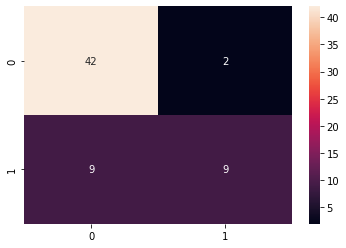

In [26]:
# detection based on the sent score distribution

def sent_dist_based_detection(df, threshold=-1.09):
    #halluc=1
    #natural_trans=0

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []
    
    for i,score in enumerate(df["sent_score"]):
        if score <= threshold:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

#     print("--"*50)

#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix, threshold
  
f_score, p_score, r_score, conf_matrix, _ = sent_dist_based_detection(df_new, threshold=-1.09)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
plt.show()


 f1_score: 0.19999999999999998 precision_score: 1.0 recall_score: 0.1111111111111111


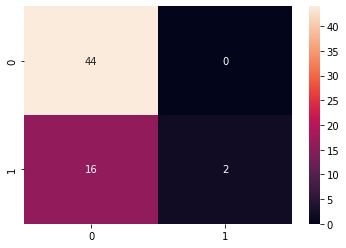

In [22]:
# detection based on the laser score distribution

def laser_dist_based_detection(df, threshold=0.778):
    #halluc=1
    #natural_trans=0

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []
    
    for i,score in enumerate(df["laser_score"]):
        if score <= threshold:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

#     print("--"*50)

#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix, threshold
  
f_score, p_score, r_score, conf_matrix, _ = laser_dist_based_detection(df_new)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
plt.show()


 f1_score: 0.7096774193548387 precision_score: 0.8461538461538461 recall_score: 0.6111111111111112


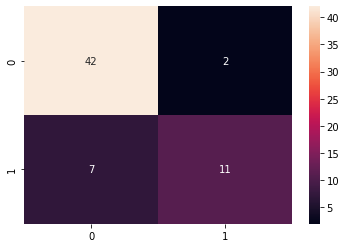

In [23]:
# detection based on the laser score distribution

def sent_laser_dist_based_detection(df, sent_threshold=-1.09, laser_threshold=0.778):
    #halluc=1
    #natural_trans=0

    orig_classes = [1 if eval=="hallucination" else 0 for i,eval in enumerate(df["annotation"])]
    pred_classes = []
    
    for i in range(len(df)):
        if df["sent_score"][i] < sent_threshold or df["laser_score"][i] < laser_threshold:
            pred_classes.append(1)
        else:
            pred_classes.append(0)

#     # check false positives
#     print("false positives")
#     for j in [i for i, v in enumerate(pred_classes) if v==1 and orig_classes[i]==0]:
#         print(df["kin"][j])

#     print("--"*50)

#     # check false negatives
#     print("false negatives")
#     for j in [i for i, v in enumerate(pred_classes) if v==0 and orig_classes[i]==1]:
#         print(df["kin"][j])

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
        
    return f_score, p_score, r_score, conf_matrix
  
f_score, p_score, r_score, conf_matrix = sent_laser_dist_based_detection(df_new, sent_threshold=-1.09, laser_threshold=0.778)
print("\n", "f1_score:", f_score, "precision_score:", p_score, "recall_score:", r_score)

sns.heatmap(conf_matrix, annot=True)
plt.show()

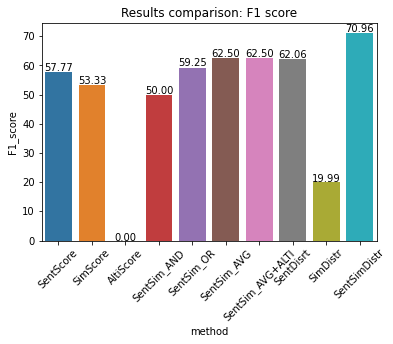

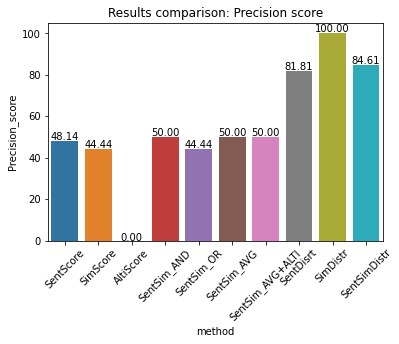

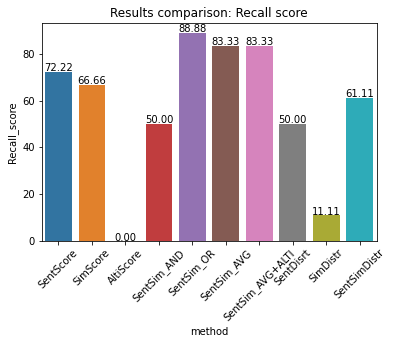

In [24]:
# results comparizon

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.0075)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

df_plot = pd.DataFrame({"method":["SentScore", "SimScore", "AltiScore", "SentSim_AND", "SentSim_OR", "SentSim_AVG", "SentSim_AVG+ALTI", "SentDisrt", "SimDistr", "SentSimDistr"],
                  "F1_score":[57.77, 53.33, 0.00, 50.00, 59.25, 62.50, 62.50, 62.06, 19.99, 70.96],
                  "Precision_score":[48.14, 44.44, 0.00, 50.00, 44.44, 50, 50, 81.81, 100.00, 84.61],
                  "Recall_score":[72.22, 66.66, 0.00, 50.00, 88.88, 83.33, 83.33, 50.00, 11.11, 61.11]})

ax_f1 = sns.barplot(x = 'method',
            y = 'F1_score',
#             hue = 'method',
            data = df_plot,
            estimator = np.median,
            ci = 0)
show_values(ax_f1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title("Results comparison: F1 score")
plt.show()

ax_precision = sns.barplot(x = 'method',
            y = 'Precision_score',
#             hue = 'method',
            data = df_plot,
            estimator = np.median,
            ci = 0)
show_values(ax_precision)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title("Results comparison: Precision score")
plt.show()

ax_recall = sns.barplot(x = 'method',
            y = 'Recall_score',
#             hue = 'method',
            data = df_plot,
            estimator = np.median,
            ci = 0)
show_values(ax_recall)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title("Results comparison: Recall score")
plt.show()

### Evaluation

sent_score_avg: -0.848294845992519
laser_score_avg 0.8663305809677417


/public/apps/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results comparison: F1 Score


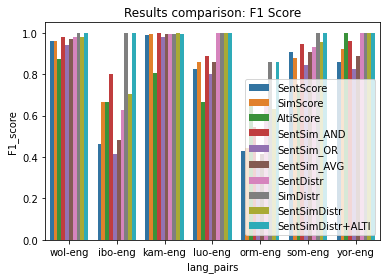

Results comparison: Precision Score


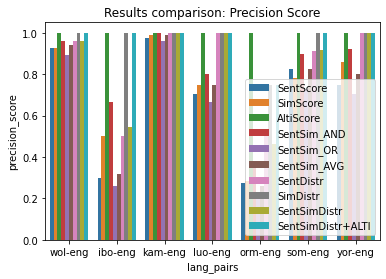

Results comparison: Recall Score


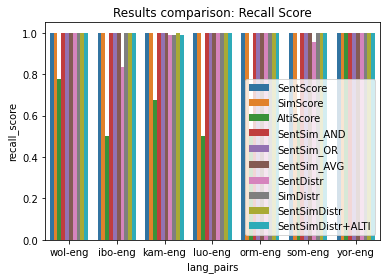

In [27]:
# evaluating the above techniques on catastrophic translation datasets of different languages.

def detect(df, sent_avg, sim_avg, alti_threshold, sent_distr_threshold, sim_distr_threshold, method):
    #halluc=1
    #natural_trans=0

    orig_classes = [1 if eval=="catastrophic" else 0 for i, eval in enumerate(df["annotation"])] # assign 1 to hallucination and 0 to natural translations
    pred_classes = []

    for i in range(len(df)):
        if method=="SentScore":
            if df.sent_score[i] <= sent_avg:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
            
        elif method=="SimScore":
            if df.sim_score[i] <= sim_avg:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        
        elif method=="AltiScore":
            if df.alti_score[i] <= alti_threshold:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
            
        elif method=="SentSim_AND":
            if df.sent_score[i] <= sent_avg and df.sim_score[i] <= sim_avg:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
            
        elif method=="SentSim_OR":
            if df.sent_score[i] <= sent_avg or df.sim_score[i] <= sim_avg:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        
        elif method=="SentSim_AVG":
            if (df.sent_score[i]+ df.sim_score[i]) <= (sim_avg+sent_avg):
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        
        elif method=="SentSim_AVG+ALTI":
            if (df.sent_score[i]+ df.sim_score[i]) <= (sim_avg+sent_avg) or df.sim_score[i] <= alti_threshold:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        elif method=="SentDistr":
            if df.sent_score[i] <= sent_distr_threshold:
                pred_classes.append(1)
            else:
                pred_classes.append(0) 
                
        elif method=="SimDistr":
            if df.sim_score[i] <= sim_distr_threshold:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
                
        elif method=="SentSimDistr":
            if df.sim_score[i] <= sim_distr_threshold or df.sent_score[i] <= sent_distr_threshold:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        elif method=="SentSimDistr+ALTI":
            if df.sim_score[i] <= sim_distr_threshold or df.sent_score[i] <= sent_distr_threshold and df.alti_score[i] <= alti_threshold:
                pred_classes.append(1)
            else:
                pred_classes.append(0)
        else:
            print("invalid method")

    f_score = f1_score(np.array(orig_classes), np.array(pred_classes))
    p_score = precision_score(np.array(orig_classes), np.array(pred_classes))
    r_score = recall_score(np.array(orig_classes), np.array(pred_classes))
    conf_matrix = confusion_matrix(orig_classes, pred_classes)
    
    return f_score, p_score, r_score, conf_matrix

if __name__=="__main__":
    _, _, _, _, sent_avg = sent_score_based_detection(df_new)
    _, _, _, _, sim_avg = laser_score_based_detection(df_new)
    _, _, _, _, alti_threshold = alti_score_based_detection(df_new)
    _, _, _, _, sent_distr_threshold = sent_dist_based_detection(df_new)
    _, _, _, _, sim_distr_threshold = laser_dist_based_detection(df_new)

    srcs = ['wol', 'ibo', 'kam', 'luo', 'orm', 'som', 'yor']
    tgt = 'eng'

    methods = []
    lang_pairs = []
    f_scores = []
    p_scores = []
    r_scores = []
    conf_matrices = []

    for method in ["SentScore", "SimScore", "AltiScore", "SentSim_AND", "SentSim_OR", "SentSim_AVG", "SentDistr", "SimDistr", "SentSimDistr", "SentSimDistr+ALTI"]:
        for src in srcs:
            methods.append(method)
            lang_pairs.append(f"{src}-{tgt}")
            df_cat = pd.read_csv(f"translations/catastrophic/{src}-{tgt}/{src}-{tgt}-balanced-eval.csv")
            if len(df_cat) >= 5:
                f_score, p_score, r_score, conf_matrix = detect(df_cat, sent_avg, sim_avg, alti_threshold, sent_distr_threshold, sim_distr_threshold, method)

                f_scores.append(f_score)
                p_scores.append(p_score)
                r_scores.append(r_score)
                conf_matrices.append(conf_matrix)
            else: 
                continue

    df_plot = pd.DataFrame({"method":methods,
                            "lang_pairs":lang_pairs, 
                            "precision_score":p_scores,
                            "F1_score":f_scores,
                            "recall_score":r_scores})

    print("Results comparison: F1 Score")
    sns.barplot(x = 'lang_pairs',
                y = 'F1_score',
                hue = 'method',
                data = df_plot,
                estimator = np.median,
                ci = 0)
    # Change the legend position
    plt.legend(loc='lower right')
    plt.title("Results comparison: F1 Score")
    plt.show()

    print("Results comparison: Precision Score")
    sns.barplot(x = 'lang_pairs',
                y = 'precision_score',
                hue = 'method',
                data = df_plot,
                estimator = np.median,
                ci = 0)

    plt.title("Results comparison: Precision Score")
    # Change the legend position
    plt.legend(loc='lower right')
    plt.show()

    print("Results comparison: Recall Score")
    sns.barplot(x = 'lang_pairs',
                y = 'recall_score',
                hue = 'method',
                data = df_plot,
                estimator = np.median,
                ci = 0)

    plt.title("Results comparison: Recall Score")
    # Change the legend position
    plt.legend(loc='lower right')
    plt.show()

#     print("confusion matrices")
#     for cfm in conf_matrices[-14:]:
#         sns.heatmap(cfm, annot=True)
#         plt.show()

## Hallucination mitigation

In [74]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/beam_rerank_comp_kin.csv")
beam_size = df["beam_size"]
plt.plot(df["beam_size"], df["Beam_base"], label="sent_score_based (baseline)")
plt.plot(df["beam_size"], df["Beam_sim"], label="laser_score_based")
plt.plot(df["beam_size"], df["Beam_sent_sim"], label="sent_laser_score_based")
plt.title("Performance on different top \n candidate selection approaches (eng-kin Flores devtest)")
plt.xlabel("beam_size")
plt.ylabel("BLEU")
plt.legend()
plt.rcParams["figure.figsize"]=6,4
plt.savefig("annotation/beam-rerank-kin.png",
                             format='png',dpi=150)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'annotation/beam_rerank_comp_kin.csv'

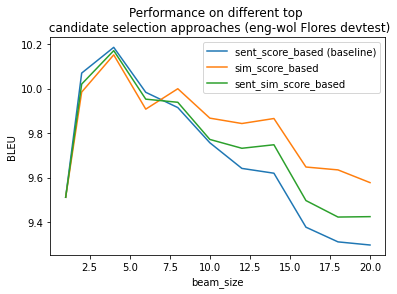

In [96]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/eng-wol-beam-rerank.csv")
beam_size = df["beam_size"]
plt.plot(df["beam_size"], df["sent_score"], label="sent_score_based (baseline)")
plt.plot(df["beam_size"], df["laser_score"], label="laser_score_based")
plt.plot(df["beam_size"], df["sent_sim"], label="sent_laser_score_based")
plt.title("Performance on different top \n candidate selection approaches (eng-wol Flores devtest)")
plt.xlabel("beam_size")
plt.ylabel("BLEU")
plt.legend()
plt.savefig("annotation/beam-rerank-wol.png",
                             format='png',dpi=150)
plt.show()

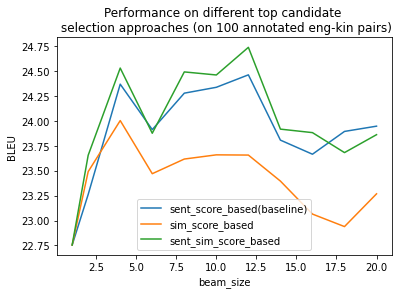

In [4]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/beam-rerank-kin-100.csv")
beam_size = df["beam_size"]
plt.plot(df["beam_size"], df["sent_score"], label="sent_score_based(baseline)")
plt.plot(df["beam_size"], df["laser_score"], label="laser_score_based")
plt.plot(df["beam_size"], df["sent_laser_score"], label="sent_laser_score_based")
plt.title("Performance on different top candidate \n selection approaches (on 100 annotated eng-kin pairs)")
plt.xlabel("beam_size")
plt.ylabel("BLEU")
plt.legend()
plt.savefig("annotation/beam-rerank-kin-100.png",
                             format='png',dpi=150)
plt.show()

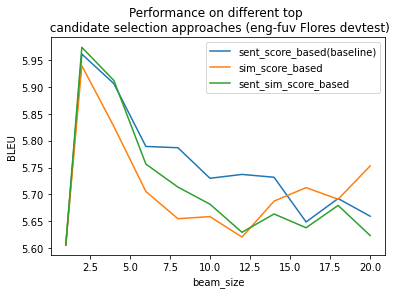

In [99]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/beam-rerank-fuv.csv")
beam_size = df["beam_size"]
plt.plot(df["beam_size"], df["sent_score"], label="sent_score_based(baseline)")
plt.plot(df["beam_size"], df["laser_score"], label="laser_score_based")
plt.plot(df["beam_size"], df["sent_laser_score"], label="sent_laser_score_based")
plt.title("Performance on different top \n candidate selection approaches (eng-fuv Flores devtest)")
plt.xlabel("beam_size")
plt.ylabel("BLEU")
plt.legend()
plt.savefig("annotation/beam-rerank-fuv.png",
                             format='png',dpi=150)
plt.show()

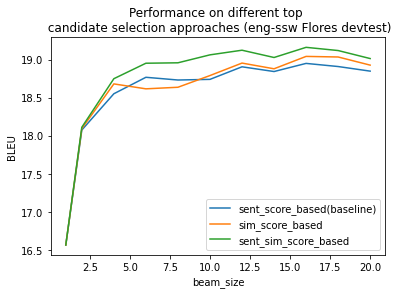

In [2]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("annotation/beam-rerank-ssw.csv")
beam_size = df["beam_size"]
plt.plot(df["beam_size"], df["sent_score"], label="sent_score_based(baseline)")
plt.plot(df["beam_size"], df["laser_score"], label="laser_score_based")
plt.plot(df["beam_size"], df["sent_laser_score"], label="sent_laser_score_based")
plt.title("Performance on different top \n candidate selection approaches (eng-ssw Flores devtest)")
plt.xlabel("beam_size")
plt.ylabel("BLEU")
plt.legend()
plt.savefig("annotation/beam-rerank-ssw.png",
                             format='png',dpi=150)
plt.show()

True